# Group Project(1)

***MEIN40330 - AI for Personalised Medicine - 2024/25 Summer***

> - **Programmer:** Yu Du
> - **Last Update:** Aug. 4<sup>th</sup>, 2025

**Keywords:** **Lung Cancer**, **TRANSACT**, **IC50**

In this final group project assignment, we selected lung cancer as our research focus. After our discussion, I primarily used two datasets — [*DepMap*](https://depmap.org/portal/data_page/?tab=allData) and [*Genomics of Drug Sensitivity in Cancer*](https://www.cancerrxgene.org/downloads/bulk_download) — to address Question 2. The datasets used for this question are as follows:

- **OmicsExpressionProteinCodingGenesTPMLogp1.csv** -- *Baseline transcriptomic data (TPM + log1p transformed) for protein-coding genes across DepMap cell lines.*
- **Model.csv** -- *Metadata file mapping DepMap internal IDs (ModelID) to CCLE names, disease types, and primary tissue origin.*
- **GDSC1_fitted_dose_response_27Oct23.xlsx / GDSC2_fitted_dose_response_27Oct23.xlsx** -- *Preprocessed drug sensitivity data from the GDSC project, reporting IC50/AUC values for cell lines treated with various drugs.*
- **screened_compounds_rel_8.5.csv** -- *Metadata for compounds tested in the GDSC dataset. Contains drug names, targets, mechanism of action, and compound identifiers.*
- **Cell_Lines_Details.xlsx** -- *Detailed annotations for cancer cell lines in the GDSC panel, including tissue of origin, cancer subtype, and other properties.*

Additionally, I have stored the raw datasets, intermediate files, and final results on [my Google Drive](https://drive.google.com/drive/folders/1pRUItYsXzlj7e49DSe1hP4wa7n4fMXRY?usp=share_link) for reference.

The required runtime environment can be set up using the following commands:
```bash
conda create -n afpm-lab-env python=3.10 -y
conda activate afpm-lab-env
pip install pandas torch scikit-learn
```

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score

# Set a random seed to ensure reproducibility
torch.manual_seed(2025)

---

## Question 2: Can you build a predictor of cell viability with respect to the drug treatments which are now standard of care? Does it in any way correlate with p.1?

In [18]:
# ========= Data Loading =========
# Read expression data (gene expression, TPM + 1, log2 processed)
expression_file = "./OmicsExpressionProteinCodingGenesTPMLogp1Stranded.csv"
expression_df = pd.read_csv(expression_file, index_col=0)

# Read cell line annotation information
model_file = "./Model.csv"
model_df = pd.read_csv(model_file)

# Read GDSC drug response data (GDSC1 and GDSC2)
gdsc1_file = "./GDSC1_fitted_dose_response_27Oct23.xlsx"
gdsc2_file = "./GDSC2_fitted_dose_response_27Oct23.xlsx"
gdsc1_df = pd.read_excel(gdsc1_file)
gdsc2_df = pd.read_excel(gdsc2_file)

# Read GDSC cell line information
cell_line_file = "./Cell_Lines_Details.xlsx"
cell_line_df = pd.read_excel(cell_line_file)

# Read drug annotation information (standard treatment drug selection)
drug_info_file = "./screened_compounds_rel_8.5.csv"
drug_info_df = pd.read_csv(drug_info_file)

/opt/miniconda3/envs/afpm-lab-env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [19]:
# ========= Data Preprocessing (GDSC Data Processing) =========
# Extract lung cancer cell line records in GDSC (by name matching)
gdsc_lung_lines = cell_line_df[cell_line_df["GDSC\nTissue descriptor 1"].str.lower().str.contains("lung", na=False)]

# Extract its COSMIC ID (for matching with GDSC1/GDSC2)
lung_cosmic_ids = set(gdsc_lung_lines["COSMIC identifier"])

# Organize the drug names of GDSC1 and GDSC2
gdsc1_drugs = set(gdsc1_df["DRUG_NAME"].dropna().unique())
gdsc2_drugs = set(gdsc2_df["DRUG_NAME"].dropna().unique())

# Screen out standard lung cancer treatment drugs (search for drugs with the following keywords in their names in screened_compounds)
standard_keywords = ["cisplatin", "carboplatin", "paclitaxel", "docetaxel", "gemcitabine", "erlotinib", "afatinib"]
standard_drugs = drug_info_df[drug_info_df["DRUG_NAME"].str.lower().str.contains('|'.join(standard_keywords))]

# Extract the intersection of these drugs in GDSC
gdsc_standard_drugs = set(standard_drugs["DRUG_NAME"]).intersection(gdsc1_drugs.union(gdsc2_drugs))

# Extract lung cancer cell line records in GDSC1 & GDSC2 (limited to standard of care drugs)
gdsc1_lung_subset = gdsc1_df[
    gdsc1_df["COSMIC_ID"].isin(lung_cosmic_ids) & 
    gdsc1_df["DRUG_NAME"].isin(gdsc_standard_drugs)
]

gdsc2_lung_subset = gdsc2_df[
    gdsc2_df["COSMIC_ID"].isin(lung_cosmic_ids) & 
    gdsc2_df["DRUG_NAME"].isin(gdsc_standard_drugs)
]

# Combine GDSC1 and GDSC2 subsets (lung cancer × standard drugs)
gdsc_lung_drug_response = pd.concat([gdsc1_lung_subset, gdsc2_lung_subset], ignore_index=True)
gdsc_lung_drug_response["CELL_LINE_NAME"] = gdsc_lung_drug_response["CELL_LINE_NAME"].str.upper()

In [20]:
# ========= Data Preprocessing (Correlation Expression Matrix) =========
# Establish the mapping relationship between ModelID and CCLEName
id_to_ccle = model_df.set_index("ModelID")["CellLineName"].dropna()

# Map expression matrix row names from DepMap IDs to CCLE names
expression_ccle_df = expression_df.copy()
expression_ccle_df.index = expression_df.index.map(id_to_ccle)

# Keep cell line rows that have drug response data
drug_cell_lines = gdsc_lung_drug_response["CELL_LINE_NAME"].unique()
matched_expression_ccle_df = expression_ccle_df[expression_ccle_df.index.str.upper().isin(drug_cell_lines)]
matched_expression_ccle_df.index = matched_expression_ccle_df.index.str.upper()

matched_response_df = gdsc_lung_drug_response[gdsc_lung_drug_response["CELL_LINE_NAME"].isin(expression_ccle_df.index)].copy()

In [21]:
# ========= Data Preprocessing (Model Training Sample Construction) =========
# Duplicate the expression feature matrix to reduce coupling and improve cohesion between steps 
X = matched_expression_ccle_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode drug name as integer (for embedding)
drug_response = matched_response_df.copy()
drug_encoder = LabelEncoder()
drug_response["DRUG_NAME_ENC"] = drug_encoder.fit_transform(drug_response["DRUG_NAME"])

# Construct samples: combining expression features + drug names line by line
X_drug = []
y_ic50 = []
drug_ids = []

for _, row in drug_response.iterrows():
    cell_line = row["CELL_LINE_NAME"]
    drug_id = row["DRUG_NAME_ENC"]
    ic50 = row["LN_IC50"]
    
    if cell_line in X.index:
        x_vec = X_scaled[list(X.index).index(cell_line)]
        X_drug.append(x_vec)
        drug_ids.append(drug_id)
        y_ic50.append(ic50)

# Convert to tensor
X_drug = torch.tensor(X_drug, dtype=torch.float32)
drug_ids = torch.tensor(drug_ids, dtype=torch.long)
y_ic50 = torch.tensor(y_ic50, dtype=torch.float32)

In [22]:
# ========= Data Modeling (Defining Data Loader) =========
class DrugResponseDataset(Dataset):
    
    def __init__(self, expr, drug_ids, labels):
        self.expr = expr
        self.drug_ids = drug_ids
        self.labels = labels

    def __len__(self):
        return len(self.expr)

    def __getitem__(self, idx):
        return self.expr[idx], self.drug_ids[idx], self.labels[idx]

In [23]:
# ========= Data Modeling (Defining Data Model) =========
class TransACT(nn.Module):
    
    def __init__(self, input_dim, drug_vocab_size, drug_embed_dim, transformer_dim, num_heads, num_layers, dropout):
        super(TransACT, self).__init__()
        self.expr_proj = nn.Linear(input_dim, transformer_dim)
        self.drug_embed = nn.Embedding(drug_vocab_size, drug_embed_dim)
        self.drug_proj = nn.Linear(drug_embed_dim, transformer_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(transformer_dim, transformer_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(transformer_dim, 1)
        )
    
    def forward(self, x_expr, drug_id):
        x_expr = self.expr_proj(x_expr)
        x_drug = self.drug_proj(self.drug_embed(drug_id))
        x_combined = x_expr + x_drug
        x_combined = x_combined.unsqueeze(0)
        x_encoded = self.encoder(x_combined)
        x_out = self.regressor(x_encoded.squeeze(0))
        return x_out.squeeze()

In [ ]:
# ========= Data Modeling (Defining Model Training) =========
def train_model(X, drug_ids, y, config, epochs=35, batch_size=32, ic50_threshold=1.0):
    
    device = torch.device("mps" if torch.backends.mps.is_available() 
                          else "cuda" if torch.cuda.is_available() 
                          else "cpu")
    print(f"Using device: {device}")

    # Train/test split
    X_train, X_test, drug_train, drug_test, y_train, y_test = train_test_split(
        X, drug_ids, y, test_size=0.2, random_state=42
    )

    train_dataset = DrugResponseDataset(X_train, drug_train, y_train)
    test_dataset = DrugResponseDataset(X_test, drug_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = TransACT(**config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    training_history = {
        "train_loss": [],
        "test_loss": [],
        "r2": [],
        "mae": [],
        "precision": [],
        "recall": []
    }

    for epoch in range(epochs):

        # Training
        model.train()
        total_loss = 0
        for x, d, y_batch in train_loader:
            x, d, y_batch = x.to(device), d.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x, d)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        training_history["train_loss"].append(avg_train_loss)

        # Evaluation
        model.eval()
        all_preds, all_labels = [], []
        test_loss_epoch = 0
        with torch.no_grad():
            for x, d, y_batch in test_loader:
                x, d, y_batch = x.to(device), d.to(device), y_batch.to(device)
                preds = model(x, d)
                loss = loss_fn(preds, y_batch)
                test_loss_epoch += loss.item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        avg_test_loss = test_loss_epoch / len(test_loader)
        r2 = r2_score(all_labels, all_preds)
        mae = mean_absolute_error(all_labels, all_preds)

        # Classification evaluation: precision and recall
        y_true_cls = (np.array(all_labels) < ic50_threshold).astype(int)
        y_pred_cls = (np.array(all_preds) < ic50_threshold).astype(int)
        precision = precision_score(y_true_cls, y_pred_cls, zero_division=0)
        recall = recall_score(y_true_cls, y_pred_cls, zero_division=0)

        # Save indicators
        training_history["test_loss"].append(avg_test_loss)
        training_history["r2"].append(r2)
        training_history["mae"].append(mae)
        training_history["precision"].append(precision)
        training_history["recall"].append(recall)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, R²: {r2:.3f}, MAE: {mae:.3f}, "
              f"Precision: {precision:.3f}, Recall: {recall:.3f}")

    return model, training_history

In [33]:
# Set up the configuration and run the model
model_config = {
    "input_dim": 19205,
    "drug_vocab_size": 8,
    "drug_embed_dim": 64,
    "transformer_dim": 128,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.2
}

model, training_history = train_model(X_drug, drug_ids, y_ic50, config=model_config)

Using device: mps


/opt/miniconda3/envs/afpm-lab-env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/35, Train Loss: 10.4772, Test Loss: 10.8333, R²: -0.005, MAE: 2.872, Precision: 0.585, Recall: 1.000
Epoch 2/35, Train Loss: 10.0684, Test Loss: 10.7270, R²: 0.005, MAE: 2.847, Precision: 0.585, Recall: 1.000
Epoch 3/35, Train Loss: 9.8929, Test Loss: 10.9547, R²: -0.017, MAE: 2.837, Precision: 0.608, Recall: 0.778
Epoch 4/35, Train Loss: 9.5759, Test Loss: 10.8657, R²: -0.010, MAE: 2.798, Precision: 0.622, Recall: 0.729
Epoch 5/35, Train Loss: 9.2839, Test Loss: 10.4750, R²: 0.028, MAE: 2.793, Precision: 0.585, Recall: 1.000
Epoch 6/35, Train Loss: 9.1147, Test Loss: 10.6867, R²: 0.011, MAE: 2.735, Precision: 0.665, Recall: 0.774
Epoch 7/35, Train Loss: 8.4304, Test Loss: 9.4301, R²: 0.128, MAE: 2.450, Precision: 0.756, Recall: 0.742
Epoch 8/35, Train Loss: 8.1080, Test Loss: 9.0316, R²: 0.162, MAE: 2.496, Precision: 0.752, Recall: 0.701
Epoch 9/35, Train Loss: 7.8499, Test Loss: 7.0648, R²: 0.344, MAE: 2.106, Precision: 0.829, Recall: 0.792
Epoch 10/35, Train Loss: 6.8037, Te

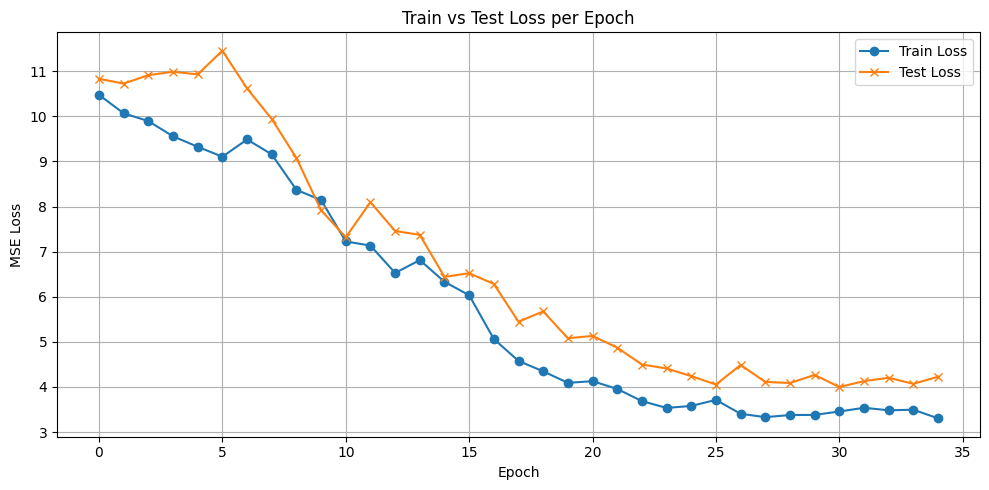

In [26]:
# Plot the training vs. test loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_history["train_loss"], label="Train Loss", marker='o')
plt.plot(training_history["test_loss"], label="Test Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

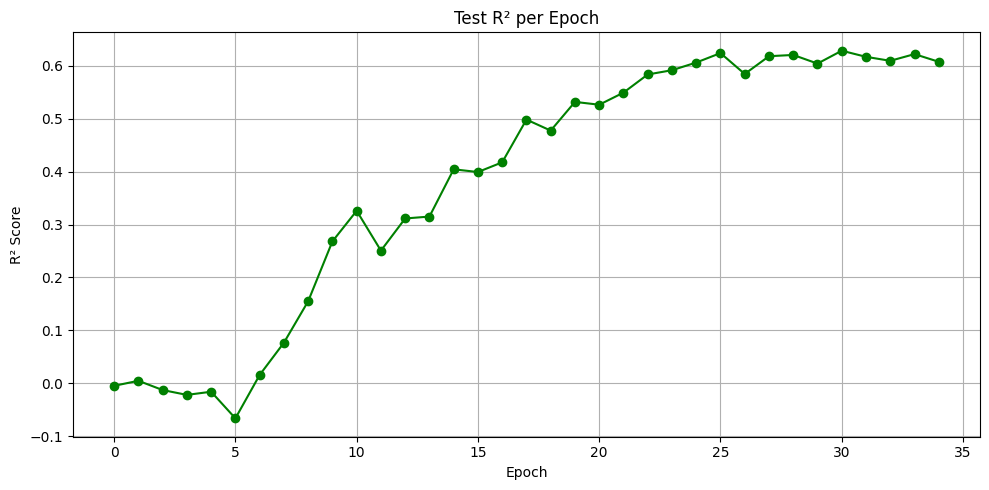

In [27]:
# Plot the R² curve
plt.figure(figsize=(10, 5))
plt.plot(training_history["r2"], label="Test R²", marker='o', color="green")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Test R² per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

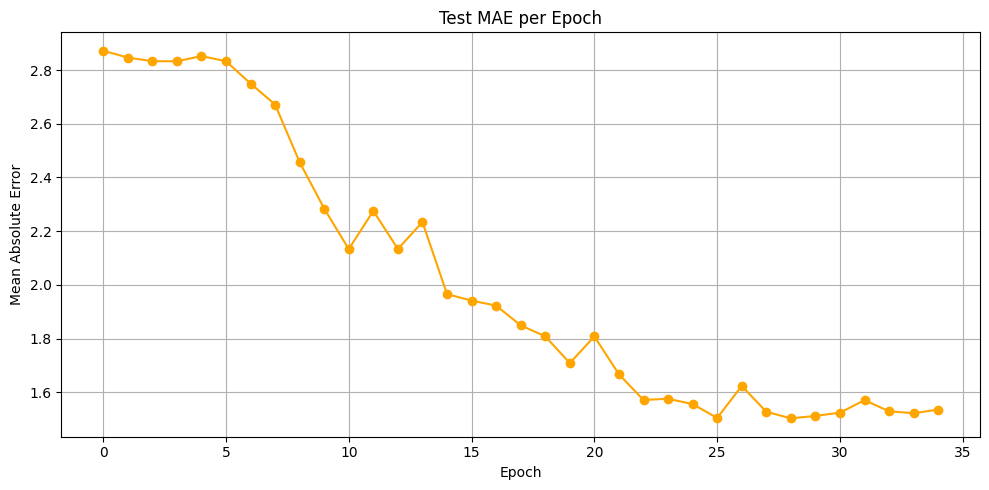

In [28]:
# Plotting the MAE curve
plt.figure(figsize=(10, 5))
plt.plot(training_history["mae"], label="Test MAE", marker='o', color="orange")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Test MAE per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

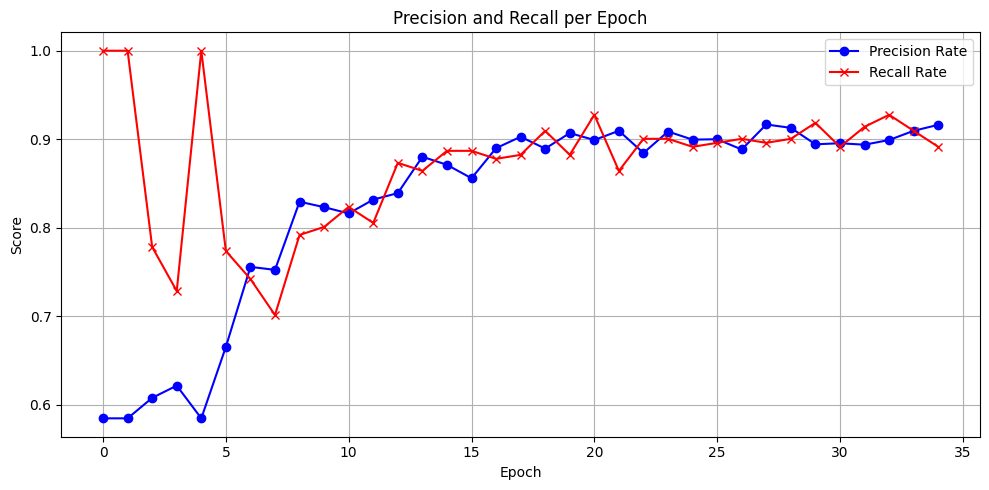

In [34]:
# Plot Precision Rate and Recall Rate curves
precision_history = training_history.get("precision", [])
recall_history = training_history.get("recall", [])

plt.figure(figsize=(10, 5))
plt.plot(precision_history, label="Precision Rate", marker='o', color="blue")
plt.plot(recall_history, label="Recall Rate", marker='x', color="red")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision and Recall per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**End of the Notebook**